# Policy gradient

Several policy gradient algorithms are implemented in this notebook:
* simple REINFORCE
* discounted reward to go
* add batch
* add reward normalization

In [1]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40)

import numpy as np
from collections import namedtuple, deque

from IPython import display
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (4,)
Number of actions:  2


In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Policy(nn.Module):
    def __init__(self, state_size = 4, hidden_size = 32, action_size = 2):
        super(Policy, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=1)
        )

    def forward(self, state):
        x = self.main(state)
        return x
    
def act(policy, state):
    state = torch.from_numpy(state).float().to(device)
    probs = policy(state).cpu()
    m = Categorical(probs)
    action = m.sample()
    log_prob =  m.log_prob(action)
    return action, log_prob


# collect one trajectory    
def collect_trajectory(env, policy, tmax):
    policy.eval()

    reward_list = []
    log_prob_list = []
    
    state = env.reset()
    state = state[np.newaxis,:] # add batch dim 
    for t in range(tmax):
        action, log_prob = act(policy, state)
        action = action.item()
        
        state, reward, done, _ = env.step(action)
        state = state[np.newaxis,:]
        
        reward_list.append(reward)
        log_prob_list.append(log_prob)
        
        if done:
            break

    return reward_list, log_prob_list

## 1. simple REINFORCE

\begin{equation}
L(\theta)=\log\pi_{\theta}(\tau)r(\tau)= \left(\sum_{t=0}^T \log\pi_{\theta}(a_{t}|s_{t})\right)
    \left(\sum_{t=0}^T \gamma^{t}r(s_{t},a_{t})\right)
\end{equation}

Episode 200	 average score 24.23
Episode 400	 average score 29.73
Episode 600	 average score 39.19
Episode 800	 average score 46.59
Episode 1000	 average score 61.31
Episode 1200	 average score 72.71
Episode 1400	 average score 93.50
Episode 1600	 average score 98.39
Episode 1800	 average score 118.64
Episode 2000	 average score 141.89
Episode 2200	 average score 162.98
Episode 2400	 average score 186.47
Episode 2600	 average score 184.90
Episode 2800	 average score 182.56
Episode 3000	 average score 192.91


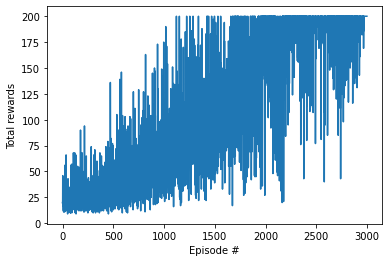

In [6]:
PRINT_EVERY = 200
NUM_EPISODES = 3000
TMAX = 200
GAMMA = 1.0
LR = 1e-3

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = LR)

score_deque = deque(maxlen = PRINT_EVERY)
score_list = []

for e in range(1, NUM_EPISODES+1):
    # collect a trajectory
    reward_list, log_prob_list = collect_trajectory(env, policy, tmax = TMAX)
    policy.train()
    score_list.append(sum(reward_list))
    score_deque.append(sum(reward_list))
            
    # compute loss
    T = len(reward_list)
    discounts = [GAMMA**i for i in range(T)]
    R = sum([a*b for a,b in zip(discounts, reward_list)]) # element-wise
    Lt = [-log_prob * R for log_prob in log_prob_list]
    L = torch.cat(Lt).sum()
    
    # update network 
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    if e % PRINT_EVERY == 0:
        print('Episode {}\t average score {:.2f}'.format(e,np.mean(score_deque)))
        
score_list1 = score_list

fig = plt.figure()
plt.plot(np.arange(len(score_list)), score_list)
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.show()

## 2. discounted reward-to-go

\begin{equation}
L(\theta)
= \sum_{t=0}^T \log\pi_{\theta}(a_t|s_t)\sum_{t'=t}^T \gamma^{t'-t}r(s_{t'},a_{t'})
=\sum_{t=0}^T \log\pi_{\theta}(a_t|s_t)\hat{Q}^{\pi}(s_t,a_t)
\end{equation}

Episode 200	 average score 33.82
Episode 400	 average score 109.70
Episode 600	 average score 171.89
Episode 800	 average score 186.33
Episode 1000	 average score 194.21
Episode 1200	 average score 198.23
Episode 1400	 average score 191.75
Episode 1600	 average score 195.94
Episode 1800	 average score 196.30
Episode 2000	 average score 197.05


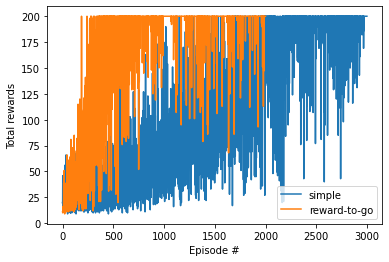

In [7]:
PRINT_EVERY = 200
NUM_EPISODES = 2000
TMAX = 200
GAMMA = 1.0
LR = 1e-3

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = LR)

score_deque = deque(maxlen = PRINT_EVERY)
score_list = []

for e in range(1, NUM_EPISODES+1):
    # collect a trajectory
    reward_list, log_prob_list = collect_trajectory(env, policy, tmax = TMAX)
    policy.train()
    score_list.append(sum(reward_list))
    score_deque.append(sum(reward_list))
            
    # compute loss
    T = len(reward_list)
    Lt = []
    for t, log_prob in enumerate(log_prob_list):
        discounts = GAMMA**np.arange(T-t)
        Rt = sum(reward_list[t:]*discounts) # element-wise
        Lt.append(-log_prob * Rt)
    L = torch.cat(Lt).sum()
    
    # update network 
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    if e % PRINT_EVERY == 0:
        print('Episode {}\t average score {:.2f}'.format(e,np.mean(score_deque)))
    
score_list2 = score_list

fig = plt.figure()
plt.plot(np.arange(len(score_list1)), score_list1, label = "simple")
plt.plot(np.arange(len(score_list2)), score_list2, label = "reward-to-go")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

## 3. use batch


\begin{equation}
L(\theta)=\frac{1}{N}\sum_{i=1}^N \log\pi_{\theta}(\tau_i)r(\tau_i).
\end{equation}

Episode 100	 average score 29.60
Episode 200	 average score 76.28
Episode 300	 average score 172.06
Episode 400	 average score 190.57
Episode 500	 average score 196.26
Episode 600	 average score 197.54
Episode 700	 average score 193.67
Episode 800	 average score 194.06
Episode 900	 average score 199.06
Episode 1000	 average score 198.24


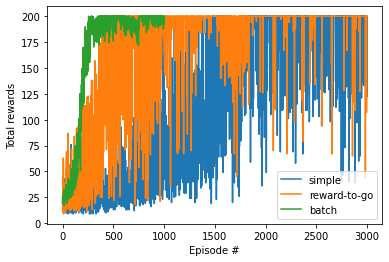

In [124]:
PRINT_EVERY = 100
NUM_EPISODES = 1000
TMAX = 1000
GAMMA = 1.0
LR = 1e-3

BATCH_SIZE = 10

policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr = LR)


score_list = []
score_deque = deque(maxlen = PRINT_EVERY)

for e in range(1, NUM_EPISODES+1):
    batch_score = []
    batch_loss = []
    for _ in range(BATCH_SIZE):
        # collect a trajectory
        reward_list, log_prob_list = collect_trajectory(env, policy, tmax = TMAX)
        policy.train()
        # compute loss
        T = len(reward_list)
        Lt = []
        for t, log_prob in enumerate(log_prob_list):
            discounts = GAMMA**np.arange(T-t)
            Rt = sum(reward_list[t:]*discounts) # element-wise
            Lt.append(-log_prob * Rt)
        L = torch.cat(Lt).sum()
        
        batch_score.append(sum(reward_list))
        batch_loss.append(L.unsqueeze(0))
        
    # batch loop ends
    score_list.append(np.mean(batch_score))
    score_deque.append(np.mean(batch_score))
    
    # update network 
    optimizer.zero_grad()
    loss = torch.cat(batch_loss).mean()
    loss.backward()
    optimizer.step()
    
    if e % PRINT_EVERY == 0:
        print('Episode {}\t average score {:.2f}'.format(e,np.mean(score_deque)))
        
score_list3 = score_list

fig = plt.figure()
plt.plot(np.arange(len(score_list1)), score_list1, label = "simple")
plt.plot(np.arange(len(score_list2)), score_list2, label = "reward-to-go")
plt.plot(np.arange(len(score_list3)), score_list3, label = "batch")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()